In [1]:
%load_ext autoreload
%autoreload 2
from itertools import product
from os import path
import numpy as np
from matplotlib import pyplot as plt
# %matplotlib notebook
%matplotlib inline
from numba import jit, prange
from tqdm.auto import tqdm
from utils import get_single_run
from sparseDynamicRecon.fidelity import GaussianGrid

import warnings; warnings.filterwarnings("ignore", message=".*a non-GUI backend")
    
from IPython.display import display, Image, HTML

SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 16, 20, 24
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', dpi=100)
plt.rc('figure', figsize=(18,10))

def figure(name, *args, figsize=(9.5,6), **kwargs):
    plt.close(name)
    f = plt.figure(name, *args, figsize=figsize, **kwargs)
    return f
def show(): plt.tight_layout()

SECS, MINS, HOURS = (1,'seconds'), (60,'minutes'), (60*60, 'hours')

## Load data and subtract background
This broadly follows what Jerome has done in his example notebook

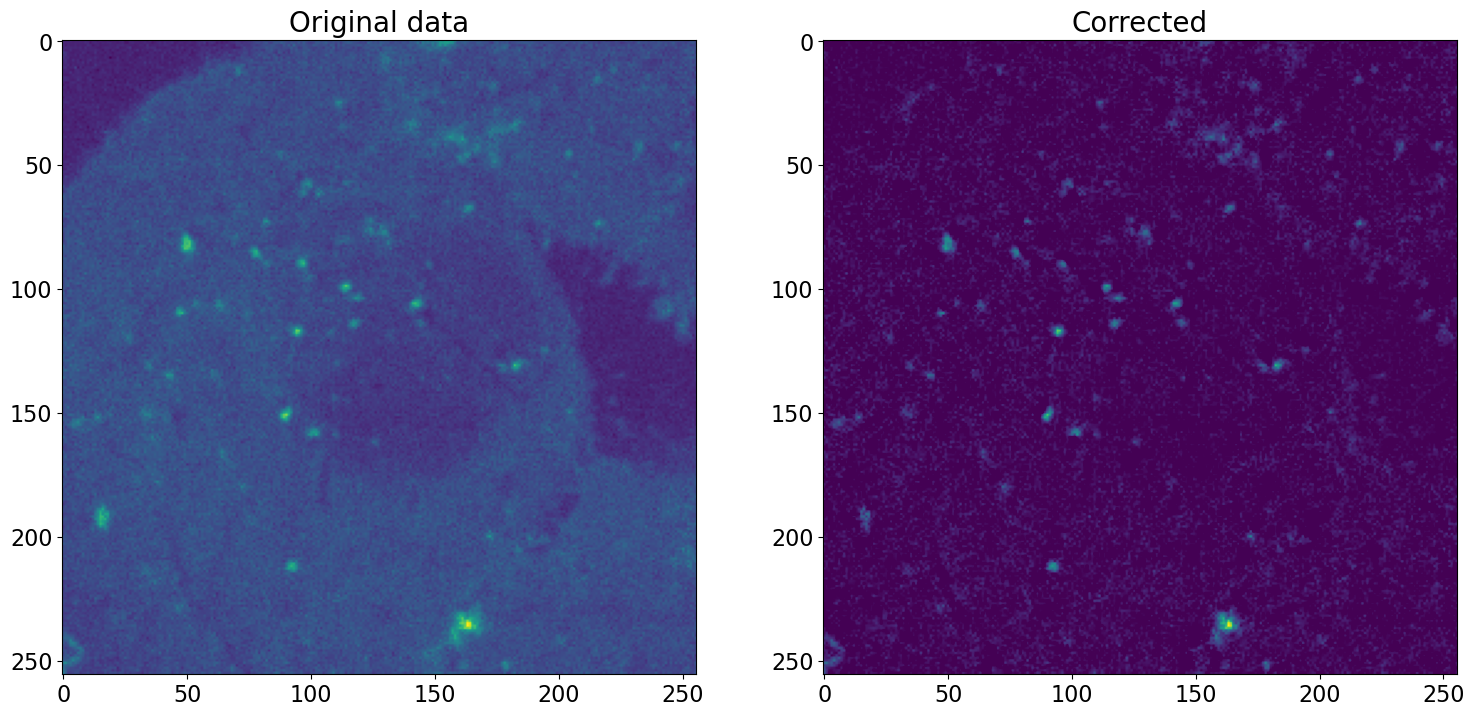

In [2]:
import tifffile
data = tifffile.imread(path.join('data','Endosomes', 'sdc9 wash dynactin arp23.tif'))
data = data[:,0,380:380+256,127:127+256] # clip to a single channel and cell
data = data/data.max()
# Assume the median in time is the background:
corrected = data - np.percentile(data,50,axis=0)
corrected /= corrected.max()
plt.subplot(121).imshow(data[0]); plt.title('Original data')
# Assume the median in time is the background:
plt.subplot(122).imshow(corrected[0],vmin=0); plt.title('Corrected')
T = np.linspace(0,1,data.shape[0])

dt, dx = T[1] - T[0], max(1 / (data.shape[1] - 1), 1 / (data.shape[2] - 1))  

# from matplotlib import rc; rc('animation', html='jshtml')
# import matplotlib.animation as animation
# def update_frame(frame):im.set_data(np.hstack((data[frame],corrected[frame]))); return im
# fig = plt.figure(); im = plt.imshow(np.hstack((data[0],corrected[0])),vmin=0,cmap='gray'); plt.axis('off')
# animation.FuncAnimation(fig, update_frame, data.shape[0], interval=100, blit=False)

data = corrected.astype('float32')

## Model
The model is defined by the `step` function which gives the cost of moving a mass $m$ from point $x$ at time $s$ to a mass $M$ at point $X$ at time $S$. Here we consider the model:
$$\operatorname{step}(m,x,s,M,X,S) = \left(\alpha(S-s) + \frac{\beta}{2}\frac{(X-x)^2}{S-s} \right)\frac{m+M}{2} + \frac{\gamma}{2}\frac{|M^{1/p}-m^{1/p}|^p}{{(S-s)^{p-1}}}$$
for some p>1.
(p=2 is not quite WFR, it would be in the limit $s\to S$)

The parameters are:
- $\alpha$ is the standard Lasso parameter, larger $\alpha$ should give sparser reconstructions but with more inaccurate mass/brightness recovery
- $\beta$ controls the spatial smoothness of curves, large values force curves to move very slowly
- $\gamma$ controls the smoothness of the change of mass/brightness of curves. The extreme case $\gamma=\infty$ is balanced transport.
- $p$ controls the flavour of smoothness in brightness where $p\approx1$ would prefer piece-wise constant and larger values would be more classically 'smooth'.

The balance between $\beta$ and $\gamma$ is quite complicated, there are two extreme (and non-physical) scenarios:
- If $\beta\gg\gamma$, then the reconstruction will be a set of static points which change brightness over time to fit the data
- If $\beta\ll\gamma$, then the reconstruction will be a set of many curves with constant mass which teleport between locations to fit the data

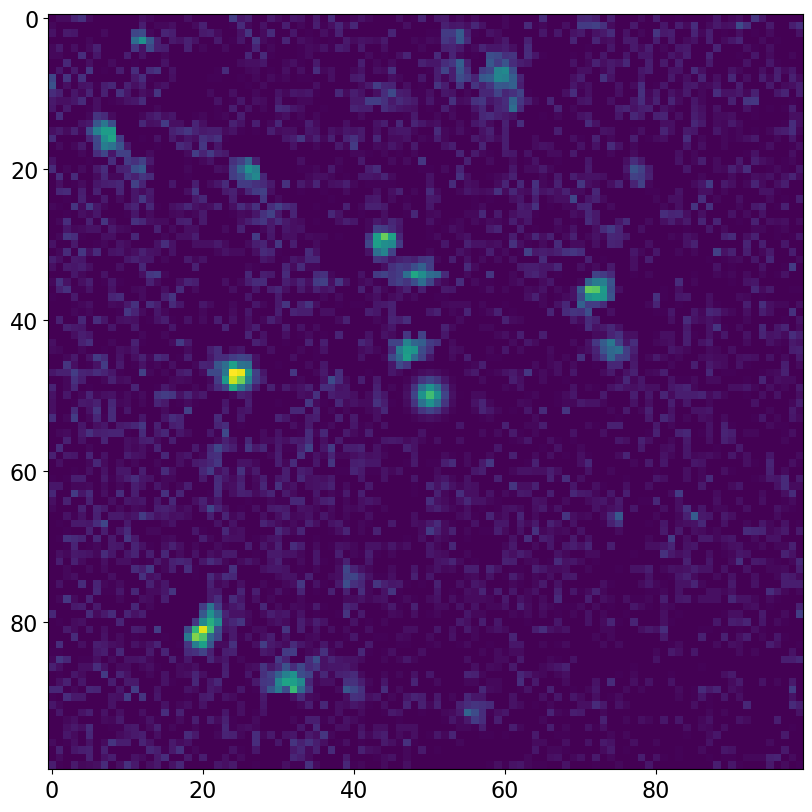

In [16]:
weight = [1e-5, 1e-4, 1e-7]  # default mass, velocity, and mass change penalties
max_velocity = 25  # maximum number of pixels to move in one frame
max_velocity *= dx/dt  # rescale to correct units
FWHM = 3; radius = FWHM / (4 * np.log(2))**.5  # radius of Gaussian in pixel units
radius *= dx  # rescale to correct units
## check radius on data, this plots one artificial psf in the middle of the data for comparison
## if you have trouble spotting it, then it's the correct radius...
from sparseDynamicRecon import DynamicMeasureSpace, CurveSpace
mySlice = slice(70, 70+100), slice(70, 70+100)
Fidelity = GaussianGrid((dx, dx), radius, 0, data=data[:2,mySlice[0],mySlice[1]])
tmp = DynamicMeasureSpace(CurveSpace(dim=2, T=T[:2], balanced=True),1).zero()+50*dx
tmp = Fidelity.fwrd(tmp)[0]
plt.imshow(data[0,mySlice[0],mySlice[1]]*(tmp<.0001)+.5*data.max()/tmp.max()*tmp,vmin=0)
plt.title('Frame of data with proposed PSF inserted in middle')

## Code for single reconstruction and saving outputs

In [4]:
# refer to the folder path.join(results,Endosomes) like this because I run code in linux and look at results in windows
single_run = get_single_run(('results', 'Endosomes'), weight, dx, FWHM, max_velocity)

# Choose parameters for reconstructions
The function `single_run` performs one reconstruction for one set of parameters $(\alpha,\beta,\gamma,p)$. This code computes multiple reconstructions over a 4d grid of values of $\alpha/\beta/\gamma$ and numbers of iterations (mainly of interest if comparing 'quick' vs. 'full' reconstructions).

The reconstructions are performed over all combinations given by `weight` and `weights`. `weight` gives a basic scaling (e.g. power of 10) so that `weights` can be of order 1. The grid of computations are then computed for each combination of 
$$(\alpha,\beta,\gamma) = (\text{weight[0]}*a, \text{weight[1]}*b, \text{weight[2]}*c) \quad\text{ for each }\quad a\in\text{weights[0]},b\in\text{weights[1]},c\in\text{weights[2]} $$
and also $\operatorname{iters}\in \text{Iters}$.

In [ ]:
p = 2 # order of penalty of mass-change, either 1.1 or 2 are obvious choices
weights = (.1,1,10,100), (1,3,10), (.1,1,10); Iters = (10.2,)
weights = (3,10), (3,10), (1,10); Iters = (1000.2,)
I = max(Iters) # hopefully most converged reconstructions
Weights = tuple(product(*weights)) # all possible combinations of alpha/beta/gamma

# Only perform the reconstruction on a slice of the data
mySlice = (slice(33), slice(128), slice(128))
small_data = np.ascontiguousarray(data[mySlice])
small_T = np.ascontiguousarray(T[mySlice[0]])

# Save the sliced data with parameters so that it can be sent to a remote computer
np.savez_compressed('Endosomes_small.npz', data=small_data, T=small_T, 
                   extras=dict(directory=('results', 'Endosomes'), weight=weight, dx=dx, FWHM=FWHM, max_velocity=max_velocity))

# Perform or load the reconstructions

In [5]:
# Utility for making videos
Fidelity = GaussianGrid((dx, dx), radius, 0, data=small_data)

# If a gif of the (sliced) data is not found then create it
datafile = path.join('results', 'Endosomes', 'data-' + '-'.join(str(d) for d in small_data.shape) + '.gif')
if not path.exists(datafile):
    if not path.exists(path.dirname(datafile)):
        import os; os.mkdir(path.dirname(datafile))
    Fidelity.gif(datafile,scale=4*255)

# Perform or load all reconstructions
fname, recon, cback, label, line_param = {}, {}, {}, {}, {}
for z in tqdm(list(product(Weights,Iters)), ncols=800):
    w, iters = z
    fname[z], recon[z], cback[z] = single_run(small_data, small_T, w, iters, p)

    ## These lines can re-make the videos with different parameters. See help(Fidelity.gif) for more info.
    ## The 'gif' shows the reconstructed/denoised video, the 'trace' overlays the positions of the curves onto the original data
#     Fidelity.gif(fname[z]['gif'], recon[z], scale=4*255)
#     Fidelity.gif(fname[z]['trace'], recon[z], scale=4*255, trace=1, trace_thresh=[.01*r for r in (.99,1)])
    
    ## create labels for plotting
    label[z] = '(%.1f, %.1f, %.3f) '%w + ('coarse-to-fine' if int(iters)==iters else 'slow-to-fast')
    line_param[z] = {
        'color':'tab:'+('blue','orange','green','red','purple')[weights[0].index(w[0])],
        'marker':' o^Dp*>'[weights[1].index(w[1])],
        'linestyle':(0,[(1,2),(3,2),(6,2),(6,2,1,2),(6,2,3,2)][weights[2].index(w[2])]),
    }

  0%|                                                                                                         …

In [6]:
HTML(f'<h1>Raw data</h1><img src="{datafile}" style="width:512px"> </img>')

# Plotting results
## Time and number of iterations to convergence

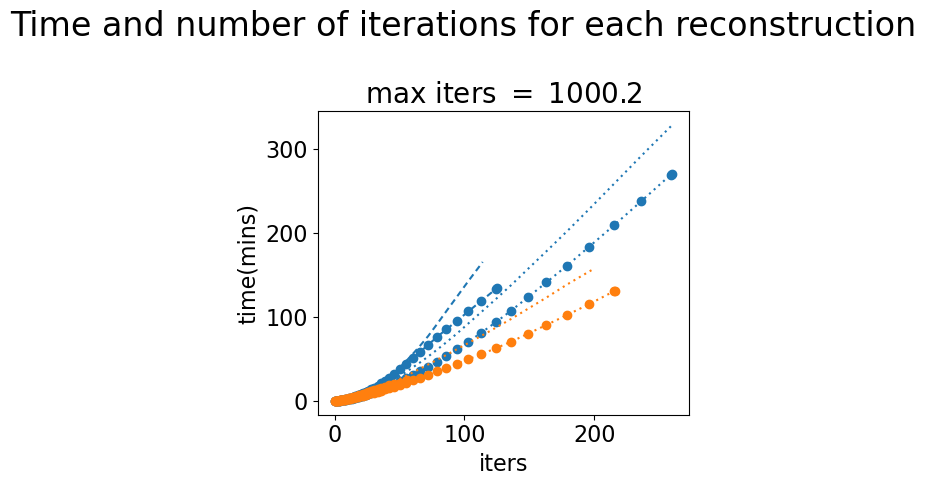

In [7]:
F = figure('converged', figsize=(5*len(Iters),5))
ax = F.subplots(1,len(Iters),sharex=True,sharey=True) if len(Iters)>1 else (F.gca(),)
for i, a in enumerate(ax):
    for z,c in cback.items():
        if z[1]==Iters[i]:
            a.plot(c.i,c.T/60, label=label[z].split(')')[0][1:], **line_param[z])
    a.set_title('max iters $ = $ %s'%Iters[i])
    a.set_xlabel('iters')
    if i==0:
        a.set_ylabel('time(mins)')
F.suptitle('Time and number of iterations for each reconstruction')
show()

## Sparsity of reconstruction

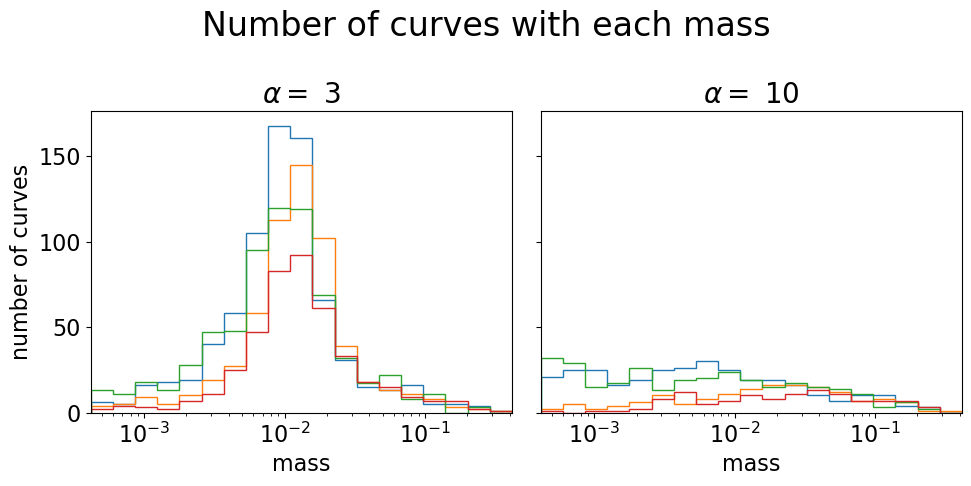

In [8]:
def masses(r):
    T = r.T; a = abs(r.a)
    if a.ndim==1:
        return a
    else:
        return .5*(a[:,1:]+a[:,:-1]).mean(1)
thresh = max(masses(r).max() for r in recon.values())
bins = np.logspace(np.log10(.001*thresh),np.log10(thresh),20)

F = figure('sparsity', figsize=(5*len(weights[0]),5))
ax = F.subplots(1,len(weights[0]), sharex=True, sharey=True) if len(weights[0])>1 else (F.gca(),)
for i, a in enumerate(ax):
    for z,r in recon.items():
        if z[0][0]==weights[0][i]:
            a.hist(masses(r),bins, histtype='step', density=False)
    a.set_title('$\\alpha = $ %s'%weights[0][i])
    a.set_xlabel('mass'); a.set_xscale('log'); a.set_xlim(bins[[0,-1]]) #a.set_yticks([]); a.set_xticklabels([])
    if i==0:
        a.set_ylabel('number of curves')
F.suptitle('Number of curves with each mass')
show()

## Step size plots

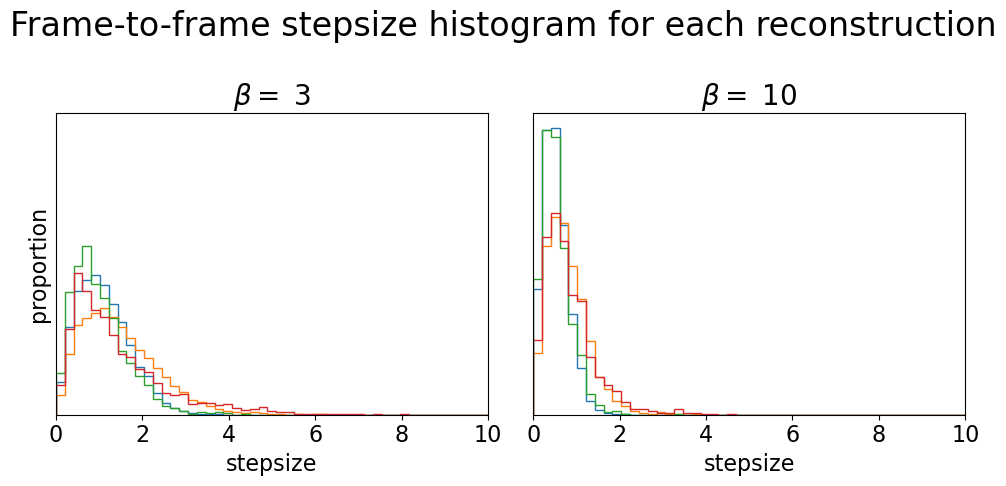

In [9]:
thresh = .01*max(r.a.max() for r in recon.values())
def vel(r):
    v = r.x[:,1:] - r.x[:,:-1] # r.shape = (N atoms, N times, 2)
    ind = (np.minimum(r.a[:,1:],r.a[:,:-1]) > thresh) # r.a.shape = (N atoms, N times)
    return (v[ind]**2).sum(axis=1)**.5
bins = np.linspace(0,10,50) # Look at jumps up to 10 pixels

F = figure('step sizes', figsize=(5*len(weights[1]),5))
ax = F.subplots(1,len(weights[1]),sharex=True,sharey=True) if len(weights[1])>1 else (F.gca(),)
for i, a in enumerate(ax):
    for z,r in recon.items():
        if z[0][1]==weights[1][i]:
#             a.plot(bins[1:], np.histogram(vel(r)/dx,bins,density=True)[0])
            a.hist(vel(r)/dx,bins, histtype='step', density=True)
    a.set_title('$\\beta = $ %s'%weights[1][i])
    a.set_xlabel('stepsize'); a.set_xlim(bins[[0,-1]]); a.set_yticks([]); #a.set_xticklabels([])
    if i==0:
        a.set_ylabel('proportion')
F.suptitle('Frame-to-frame stepsize histogram for each reconstruction')
show()

## Mass conservation plots

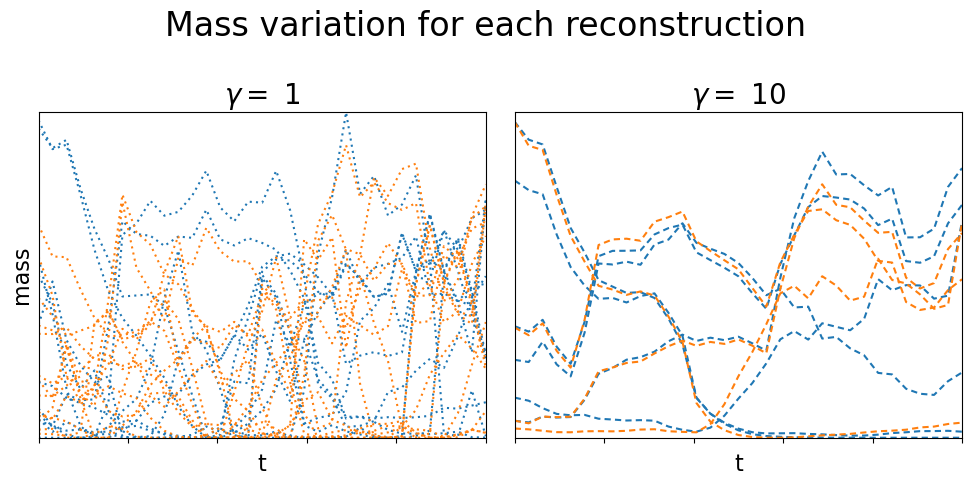

In [10]:
thresh = max(r.a.max() for r in recon.values())
F = figure('mass conservation', figsize=(5*len(weights[2]),5))
ax = F.subplots(1,len(weights[2]),sharex=True,sharey=True) if len(weights[2])>1 else (F.gca(),)
for i, a in enumerate(ax):
    for z in recon:
        if z[0][2]==weights[2][i]:
            a.plot(recon[z].T, recon[z].a[recon[z].a.max(1)>.6*thresh].T, **line_param[z], markersize=0, label=(str(z[0][:2]) if i==0 else None))
    a.set_title('$\\gamma = $ %s'%weights[2][i])
    a.set_xlabel('t'); a.set_yticks([]); a.set_xticklabels([])
    if i==0:
        a.set_ylabel('mass')
a.set_ylim(0,thresh); a.set_xlim(recon[z].T[[0,-1]]);
F.suptitle('Mass variation for each reconstruction')
show()

## Final fidelity of each reconstruction

## Gifs of top/bottom 5 reconstructions in order of data-fidelity

In [11]:
E = {w:Fidelity(recon[(w,I)]) for w in Weights}
m,M = min(E.values()), max(E.values())
E = {w:(E[w]-m)/(M-m) for w in Weights}

def best(L,n, reverse=False):
    L = sorted(L, key=((lambda w:-E[w]) if reverse else (lambda w: E[w])))
    return L[:n]
def rowify(L,n=3):
    s, i = '', 0
    while n*i<len(L):
        s = s + '\n<tr>\n\t' + '\n\t'.join(row[w] for w in L[n*i:n*(i+1)]) + '\n</tr>'
        i += 1
    return s
def tablify(rows):
    rows = rows.replace('<img', '''<img onclick='document.querySelectorAll("table img").forEach(function (I) {I.setAttribute("src",I.src)})' ''')
    return f'<table style="width:100%;table-layout:fixed;"> {rows} </table>'
def argmin(I):
    E = {w:Fidelity(recon[(w,I)]) for w in Weights}
    Emin = min(E.values())
    return [w for w in Weights if E[w]==Emin][0], I

# for s in ('gif',):# 'trace'):
#     html = '<td> <p style="text-align:center"> %s, %.3f </p> <img src="%s" style="width:100%%"> </img> </td>'
#     row = {w:html % (w,E[w],path.join(*fname[(w,I)][s])) for w in Weights}; row['GT'] = html % ('Ground-Truth',m/(M-m),datafile)
#     t = ', showing ' + ('data projection' if s == 'gif' else 'trajectories')

#     display(HTML('<h1> Data-space reconstructions ordered by energy. Printed energy is linearly rescaled so that reconstructions are in [0,1].</h1>'
#         + f'<h2> Best 5{t}</h2>' + tablify(rowify(['GT']+best(Weights,5)))
#         + f'<h2> Worst 5{t}</h2>' + tablify(rowify(['GT']+best(Weights,5,True)))
#         + f'<h2> Best for each mass penalty{t}</h2>' +
#             tablify(rowify(['GT']+sum([best([w for w in Weights if w[0]==ww],1) for ww in weights[0]],[])))
#         + f'<h2> Best for each velocity penalty{t}</h2>' +
#             tablify(rowify(['GT']+sum([best([w for w in Weights if w[1]==ww],1) for ww in weights[1]],[])))
#         + f'<h2> Best for each mass-change penalty{t}</h2>' +
#             tablify(rowify(['GT']+sum([best([w for w in Weights if w[2]==ww],1) for ww in weights[2]],[])))
#     ))

#     # Show best reconstruction for each algorithm variant:
#     tmp = {0:'default',.1:'non-binary initialisation',.2:'slow-to-fast search',.9:'initialising 10000 atoms per iteration'}
#     tmp = {k:v for k,v in tmp.items() if any(i for i in Iters if np.isclose(i%1,k))}
#     html = '<td> <p style="text-align:center"> %s </p> <img src="%s" style="width:100%%"> </img> </td>'
#     L = {d:argmin(max(i for i in Iters if np.isclose(i%1,d))) for d in tmp}
#     row = [html % ('Ground-Truth',datafile)] + [html % (tmp[d],path.join(*fname[z][s])) for d,z in L.items()]
#     S, i = '', 0
#     while 3*i<len(L):
#         S = S + '\n<tr>\n\t' + '\n\t'.join(row[3*i:3*(i+1)]) + '\n</tr>'
#         i += 1
#     display(HTML('<h1> Best reconstruction for each algorithm variant.</h1>' + tablify(S)))
# HTML('<script>document.querySelectorAll("table img").forEach(function (I) {I.setAttribute("src",I.src)}); </script>')

# Plot curves for favourite reconstruction
In what follows, `r` is the optimal reconstruction. It represents a collection of curves with `mass`, `x`, and `y` coordinates at each time point, this is stored in a large array 

` r.arr.reshape(number of curves, number of timepoints, 3) = [curve0,curve1,curve2,...]` 
where 

`curve0 = [ [mass0, x0, y0], [mass1, x1, y1], ... ]`.

There are some additional helper attributes/methods:
- `r.arr[i,3*t] = curve[i][t][0] = r.a[i,t]` is an array of masses/brightnesses
- `r.arr[i,3*t+1:3*t+3] = curve[i][t][1:3] = r.x[i,t]` is an array of coordinates
- `r.T` is the array of timepoints corresponding to the `t` index above

((3, 10), (3, 10), (1, 10))


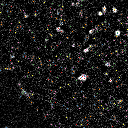

In [12]:
print('Possible choice of weights are:', weights)
z = (10,3,1),I
r = recon[z]
# set threshold for 'true' detection of path
threshold = .01*r.a.max()

Image(path.join(*fname[z]['trace']), width=768)
# HTML('<h1>Best trace?</h1><img src="%s" style="width:768px"> </img>'%path.join(*fname[z]['trace']))

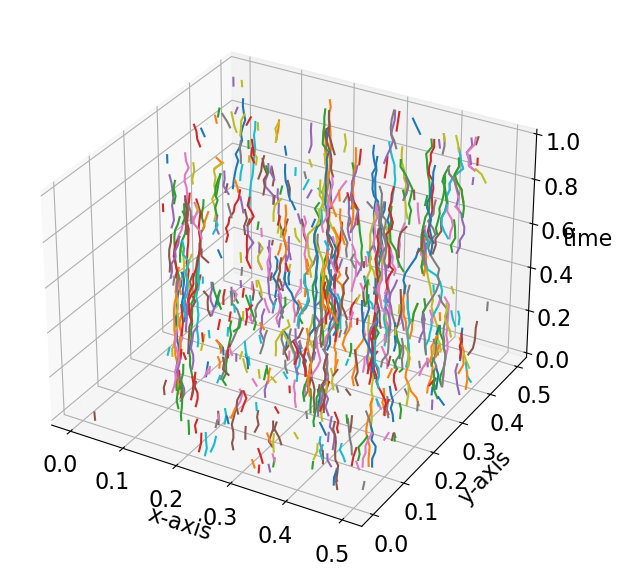

In [13]:
# represent the tracks in 3D
from mpl_toolkits import mplot3d
F = figure('tracks in 3D', figsize=(18,6)); ax = plt.axes(projection='3d')
for track in r.arr:
    ind = (track[::3] > threshold).astype(float); ind[ind==0] = np.nan
    ax.plot(track[1::3],track[2::3],r.T*ind)
ax.set_xlabel('x-axis'); ax.set_ylabel('y-axis'); ax.set_zlabel('time')
show()

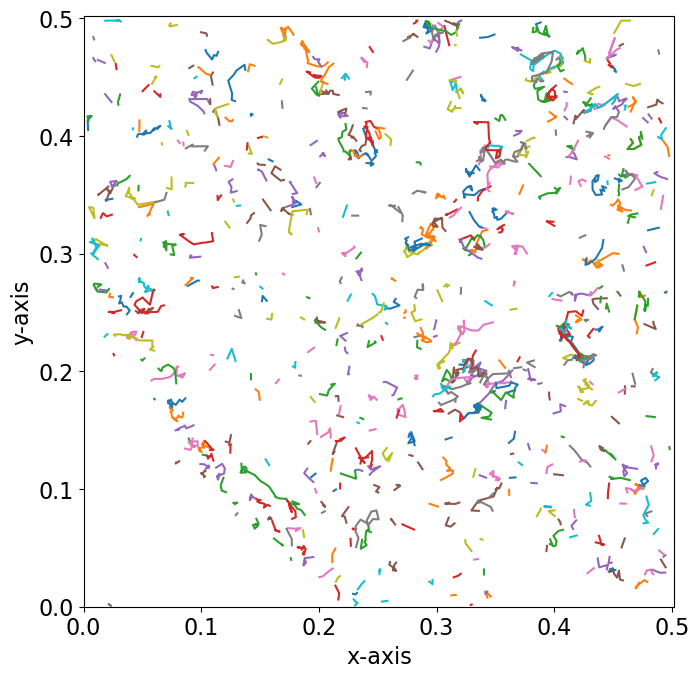

In [14]:
# represent the tracks in 2D
figure('tracks in 2D', figsize=(10,7))
for track in r.arr:
    ind = (track[::3] > threshold).astype(float); ind[ind==0] = np.nan
    plt.plot(track[1::3],track[2::3]*ind)
plt.xlabel('x-axis'); plt.ylabel('y-axis')
plt.gca().set_aspect('equal'); show()
plt.ylim(0,small_data.shape[2]*dx); plt.xlim(0,small_data.shape[1]*dx);

Originally 16224 steps, 2539 after threshold.
Mean step is [ 1.543e-04 -6.381e-05], std. is [0.003 0.003] per frame (assuming original image is width 1).
In pixel units, these are [ 0.039 -0.016] and [0.843 0.852] respectively.


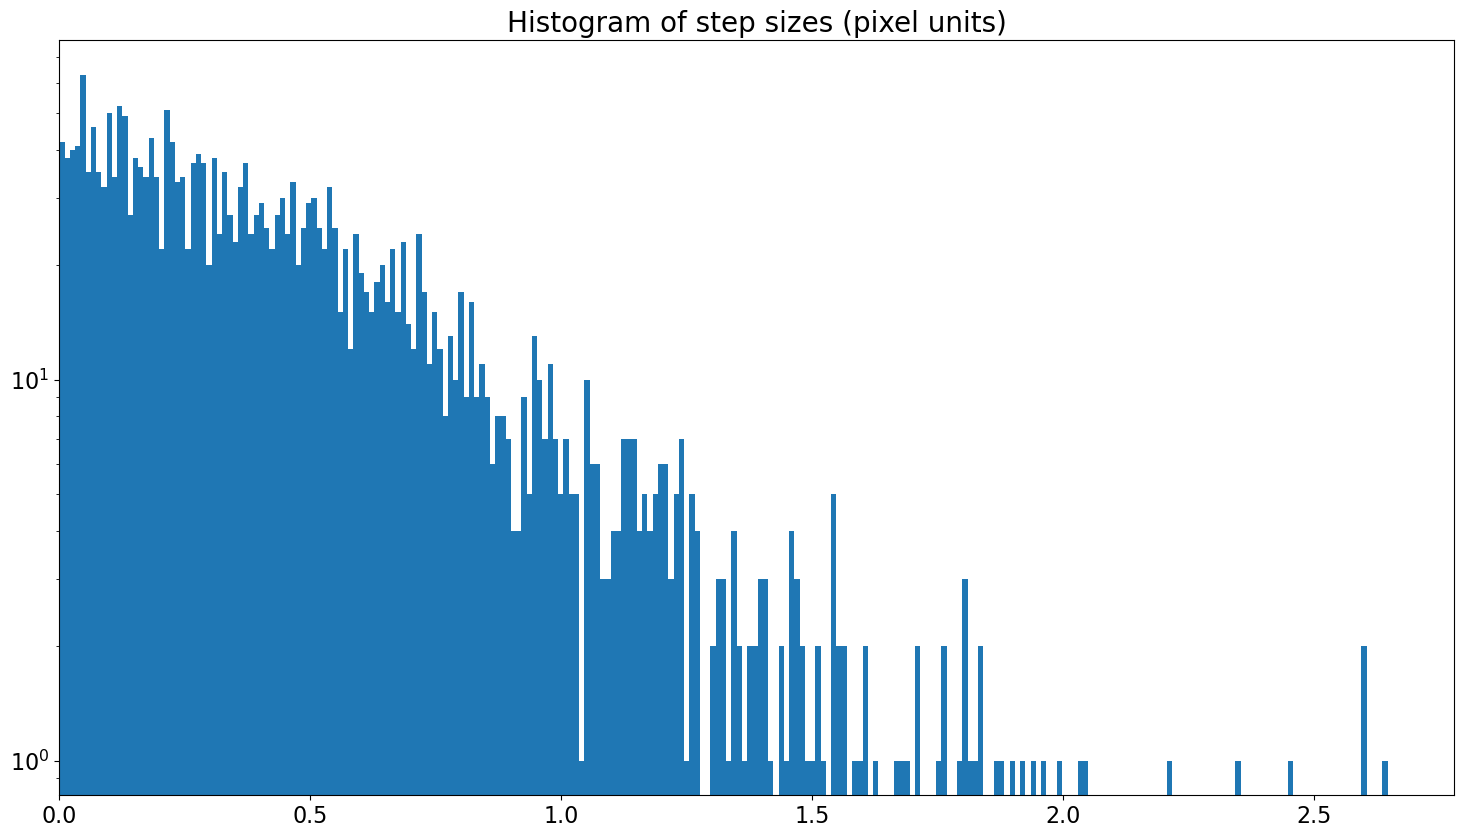

In [15]:
# r.arr = [ [a0,x0,x] ]

# plot velocity distribution
v = r.x[:,1:] - r.x[:,:-1] # r.x.shape = (N atoms, N times, 2)
ind = (np.minimum(r.a[:,1:],r.a[:,:-1]) > threshold) # r.a.shape = (N atoms, N times)
print(f'Originally {v[...,0].size} steps, {ind.sum()} after threshold.')
v = v[ind]
np.set_printoptions(precision=3)
print(f'Mean step is {v.mean(axis=0)}, std. is {v.std(axis=0)} per frame (assuming original image is width 1).')
print(f'In pixel units, these are {v.mean(axis=0)/dx} and {v.std(axis=0)/dx} respectively.')
# print(f'In velocity units, these are {v.mean(axis=0)/dt} and {v.std(axis=0)/dt} respectively.')
plt.hist(v.std(axis=1)/dx,v.shape[0]//10,log=True);
plt.title('Histogram of step sizes (pixel units)');plt.axis('tight');plt.xlim(0,None);